In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\nLumberJack Jyss (c)')

Global Optimized LumberJack Equities Method
LumberJack Jyss (c)


In [3]:
from utils import *
from collections import deque
import bert
import time
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas_datareader as web
from yahoofinancials import YahooFinancials
import math
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [6]:
start = '2010-01-01'
end = '2019-05-01'
dataset_ex_df = web.DataReader('GS','yahoo',start,end)
dataset_ex_df['Date']=dataset_ex_df.index
cols = dataset_ex_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
dataset_ex_df = dataset_ex_df[cols]
dataset_ex_df.columns = dataset_ex_df.columns.str.replace('Adj Close','GS')
dataset_ex_df.reset_index(drop=True,inplace=True)
dataset_ex_df.head()

,Date,High,Low,Open,Close,Volume,GS
0,2010-01-04,174.250000,169.509995,170.050003,173.080002,9135000.0,150.662186
1,2010-01-05,176.259995,172.570007,173.000000,176.139999,11659400.0,153.325790
2,2010-01-06,175.380005,173.759995,175.380005,174.259995,7381100.0,151.689255
3,2010-01-07,178.750000,173.949997,174.320007,177.669998,8727400.0,154.657593
4,2010-01-08,177.429993,173.949997,176.330002,174.309998,7268100.0,151.732819


In [7]:
GS = dataset_ex_df['GS']
dataset_ex_df[['Date', 'GS']].head(3)

,Date,GS
0,2010-01-04,150.662186
1,2010-01-05,153.325790
2,2010-01-06,151.689255


In [8]:
jpm = web.DataReader('JPM','yahoo',start,end) # (2347, 6)
ms = web.DataReader('MS','yahoo',start,end) #(2347, 6
#ulbr = web.DataReader('ULBR','yahoo',start,end) #(420, 6)
#dlbr = web.DataReader('DLBR','yahoo',start,end) #(430, 6)
vix = web.DataReader('^VIX','yahoo',start,end) #(2347, 6)

In [9]:
jpm.shape,ms.shape,vix.shape

((2347, 6), (2347, 6), (2347, 6))

In [10]:
nasdaq = web.DataReader('^IXIC','yahoo',start,end) #(2347, 6)
nyse = web.DataReader('^NYA','yahoo',start,end) #(2347, 6)
#ftse100 = web.DataReader('^FTSE','yahoo',start,end)
nikkei = web.DataReader('^N225','yahoo',start,end) #(2286, 6)
bsesensex = web.DataReader('^BSESN','yahoo',start,end) #(2291, 6

In [11]:
nasdaq.shape,nyse.shape,nikkei.shape,bsesensex.shape

((2347, 6), (2347, 6), (2286, 6), (2291, 6))

In [22]:
per = web.DataReader('PER','yahoo',start,end) #(1942, 6)
vym = web.DataReader('VYM','yahoo',start,end) #(2347, 6) 
schd = web.DataReader('SCHD','yahoo',start,end) #(1893, 6) 
spyd = web.DataReader('SPYD','yahoo',start,end) #(886, 6) 

In [23]:
per.shape,vym.shape,schd.shape,spyd.shape

((1942, 6), (2347, 6), (1893, 6), (886, 6))

In [24]:
per.head(1)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2011-08-11,18.1,17.559999,18.0,18.0,12341100.0,3.986198


In [25]:
currencies = ['EURJPY=X', 'GBPJPY=X', 'USDJPY=X','GBPUSD=X','BTCUSD=X','ETHUSD=X','GBPEUR=X',\
             'GBPSGD=X','GBPSEK=X','GBPSAR=X','CADUSD=X','CADJPY=X','AUDUSD=X','NZDUSD=X',\
             'NZDGBP=X','NZDEUR=X','AUDGBP=X','AUDEUR=X',]
daily_currency_prices = YahooFinancials(currencies).get_historical_price_data(start,end,'daily')
temp_df = pd.DataFrame.from_dict(daily_currency_prices.values()).T

In [17]:
eurusd = pd.DataFrame.from_dict(temp_df.iloc[4,0]).iloc[:,0] #(2434,)
gbpjpy = pd.DataFrame.from_dict(temp_df.iloc[4,1]).iloc[:,0] #(2434,)
usdjpy = pd.DataFrame.from_dict(temp_df.iloc[4,2]).iloc[:,0] #(2434,)
gbpusd = pd.DataFrame.from_dict(temp_df.iloc[4,3]).iloc[:,0] #(2434,)
btcusd = pd.DataFrame.from_dict(temp_df.iloc[4,4]).iloc[:,0] #(2293,)
#ethusd = pd.DataFrame.from_dict(temp_df.iloc[4,5]).iloc[:,0] #(974,)
gbpeur = pd.DataFrame.from_dict(temp_df.iloc[4,6]).iloc[:,0] #(2434,)
gbpsgd = pd.DataFrame.from_dict(temp_df.iloc[4,7]).iloc[:,0] #(2434,)
gbpsek = pd.DataFrame.from_dict(temp_df.iloc[4,8]).iloc[:,0] #(2434,)
gbpsar = pd.DataFrame.from_dict(temp_df.iloc[4,9]).iloc[:,0] #(2433,)
cadusd = pd.DataFrame.from_dict(temp_df.iloc[4,10]).iloc[:,0] #(2434,) 
cadjpy = pd.DataFrame.from_dict(temp_df.iloc[4,11]).iloc[:,0] #(2434,)
audusd = pd.DataFrame.from_dict(temp_df.iloc[4,12]).iloc[:,0] #(2434,)
nzdusd = pd.DataFrame.from_dict(temp_df.iloc[4,13]).iloc[:,0] #(2434,)
nzdgbp = pd.DataFrame.from_dict(temp_df.iloc[4,14]).iloc[:,0] #(2434,)
nzdeur = pd.DataFrame.from_dict(temp_df.iloc[4,15]).iloc[:,0] #(2434,)
audgbp = pd.DataFrame.from_dict(temp_df.iloc[4,16]).iloc[:,0] #(2434,) 
audeur = pd.DataFrame.from_dict(temp_df.iloc[4,17]).iloc[:,0] #(2434,)

ValueError: If using all scalar values, you must pass an index

In [17]:
eurusd.shape, btcusd.shape

((2434,), (2293,))

In [21]:
temp_df.iloc[4,0]

{'gmtOffset': 0}

In [18]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2347 number of days in the dataset.


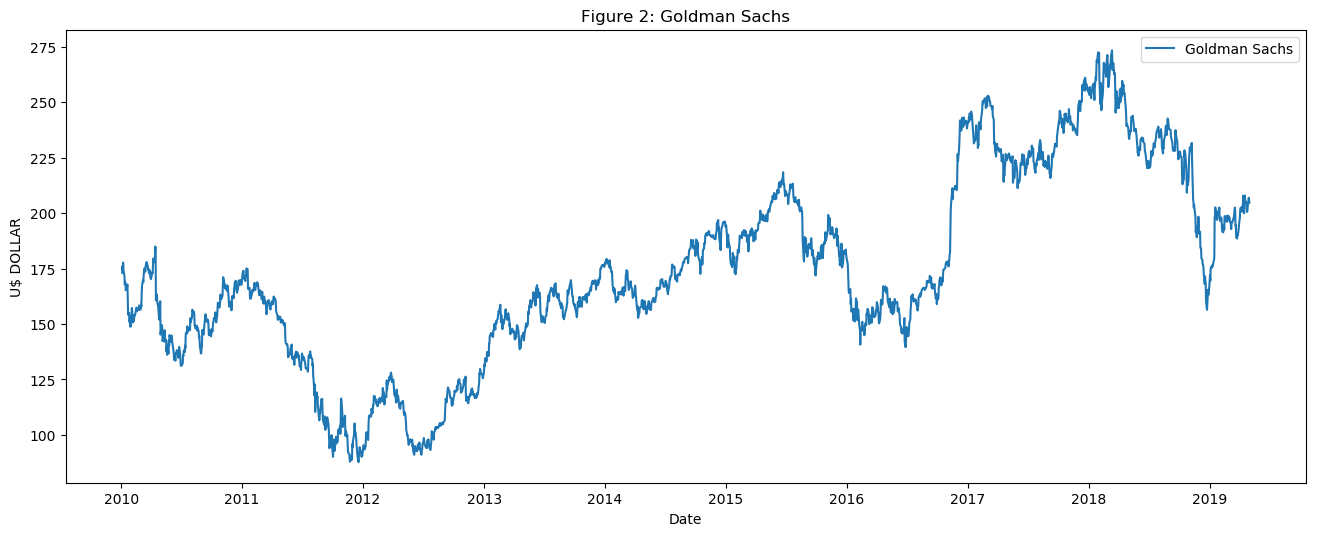

In [19]:
plt.figure(figsize=(16, 6), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs')
#plt.vlines(datetime.date(20180506), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('U$ DOLLAR')
plt.title('Figure 2: Goldman Sachs')
plt.legend()
plt.show()

In [20]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1642. Number of test days: 705.


In [21]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['GS'].rolling(window=7).mean()
    dataset['ma21'] = dataset['GS'].rolling(window=21).mean()
    
    # Create MACD
    
    dataset['26ema'] = talib.EMA(dataset['GS'],timeperiod=26)
    dataset['12ema'] = talib.EMA(dataset['GS'],timeperiod=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    upperband, middleband, lowerband = \
    talib.BBANDS(dataset['GS'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    dataset['20sd'] = middleband
    dataset['upper_band'] = upperband
    dataset['lower_band'] = lowerband
    
    # Create Exponential moving average
    dataset['ema'] = talib.EMA(dataset['GS'],timeperiod=30)
    
    # Create Momentum
    #dataset['momentum'] = dataset['GS']-1
    dataset['momentum'] = dataset['GS'].pct_change()
    
    return dataset

In [22]:
dataset_ex_df2 = dataset_ex_df.drop(['High','Low','Open','Close','Volume','GS'],axis=1)
dataset_ex_df2['GS'] = GS

In [23]:
len(dataset_ex_df2['GS'].pct_change())

2347

In [24]:
dataset_ex_df2.head()

,Date,GS
0,2010-01-04,153.149658
1,2010-01-05,155.857300
2,2010-01-06,154.193787
3,2010-01-07,157.211121
4,2010-01-08,154.238022


In [25]:
dataset_ex_df2.isnull().sum()

Date    0
GS      0
dtype: int64

In [26]:
dataset_TI_df = get_technical_indicators(dataset_ex_df2)

In [27]:
dataset_TI_df = dataset_TI_df.dropna()
dataset_TI_df.head()

,Date,GS,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
29,2010-02-16,139.275238,136.110003,137.739806,141.431635,137.073431,-4.358204,137.317503,145.925169,128.709837,142.207031,0.022543
30,2010-02-17,139.151352,136.501862,137.404829,141.262725,137.393111,-3.869614,136.892776,144.152791,129.632760,142.009890,-0.000890
31,2010-02-18,137.797516,137.087121,136.935859,141.006043,137.455327,-3.550715,136.359212,141.352400,131.366023,141.738124,-0.009729
32,2010-02-19,138.195740,137.553569,136.446665,140.797872,137.569237,-3.228635,136.151717,140.425691,131.877744,141.509583,0.002890
33,2010-02-22,138.664688,137.942904,136.271383,140.639858,137.737768,-2.902091,136.266307,140.678511,131.854103,141.326042,0.003393


In [28]:
dataset_TI_df.shape

(2318, 12)

In [29]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='orange',linestyle='--')
    plt.plot(dataset['GS'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.25)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='orange', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='orange', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

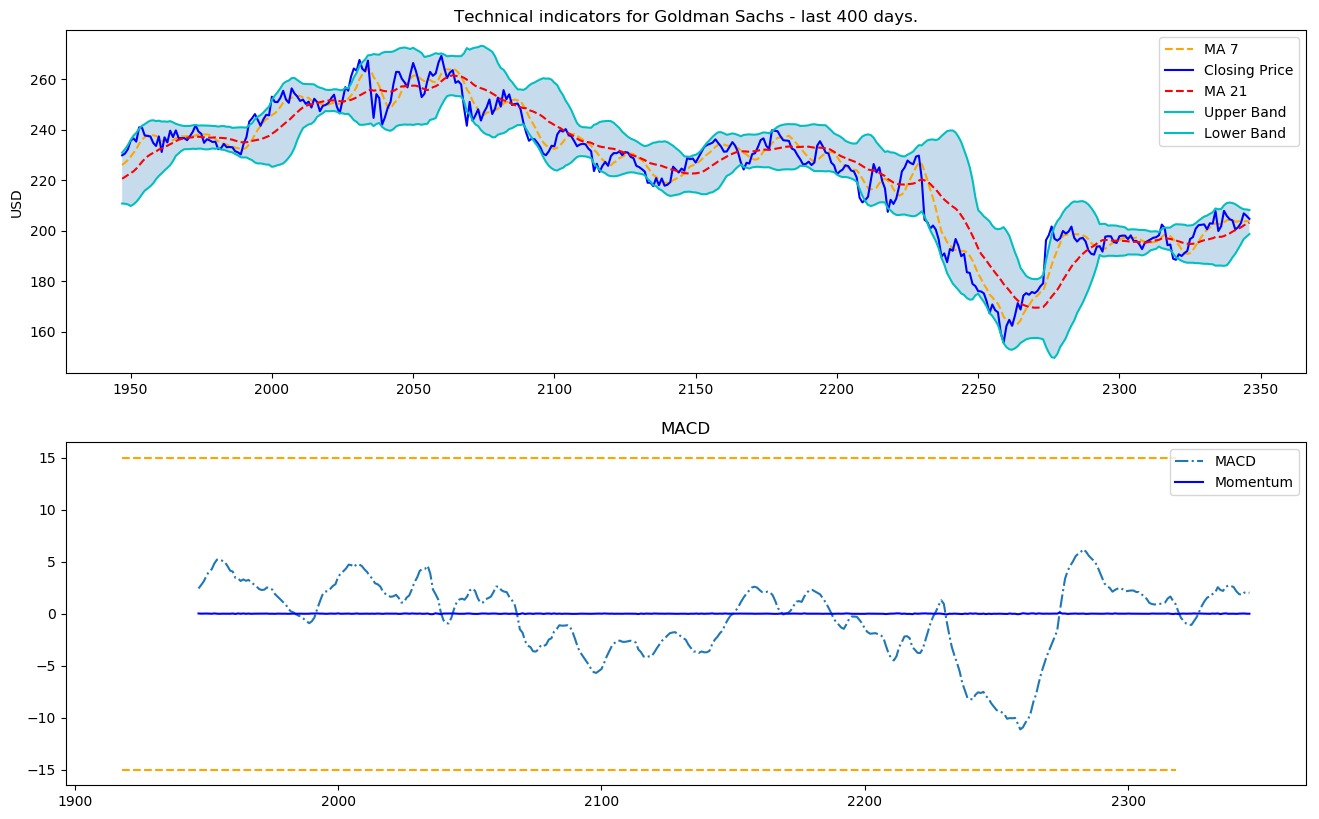

In [30]:
plot_technical_indicators(dataset_TI_df, 400)

In [31]:
data_FT = dataset_ex_df[['Date', 'GS']]
data_FT.head()

,Date,GS
0,2010-01-04,153.149658
1,2010-01-05,155.857300
2,2010-01-06,154.193787
3,2010-01-07,157.211121
4,2010-01-08,154.238022


In [32]:
len( np.fft.fft(np.asarray(data_FT.iloc[:-1,1].tolist()))),len(data_FT.iloc[:-1,1])
toto = data_FT['GS'].shift(-1)
toto.head()

0    155.857300
1    154.193787
2    157.211121
3    154.238022
4    151.804703
Name: GS, dtype: float64

In [33]:
np.fft.fft(np.asarray(toto.dropna().tolist()))

array([385175.58167267    +0.j        ,  11853.80736277+59079.97658993j,
        14411.22336283+26689.90946514j, ...,
       -14885.74175021 -4080.97117995j,  14411.22336283-26689.90946514j,
        11853.80736277-59079.97658993j])

In [34]:
close_fft = np.fft.fft(np.asarray(toto.dropna().tolist()))
fft_df = pd.DataFrame({'fft':close_fft},index=toto.dropna().index)
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_df.tail()

,fft,absolute,angle
2341,(1809.6365686402119-11058.186374258836j),11205.278685,-1.408587
2342,(-11680.475357209534+6682.0289427225425j),13456.708935,2.621964
2343,(-14885.741750212213-4080.971179953397j),15435.013224,-2.874014
2344,(14411.223362826835-26689.909465142056j),30332.072565,-1.075702
2345,(11853.807362770578-59079.976589933765j),60257.417658,-1.372785


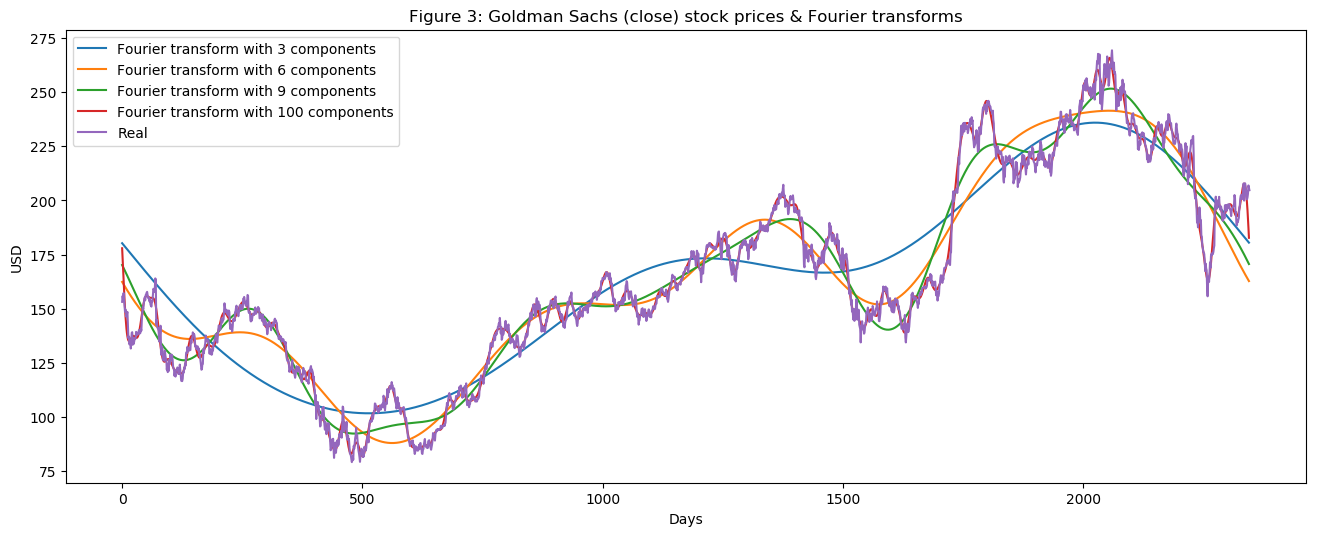

In [35]:
plt.figure(figsize=(16, 6), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

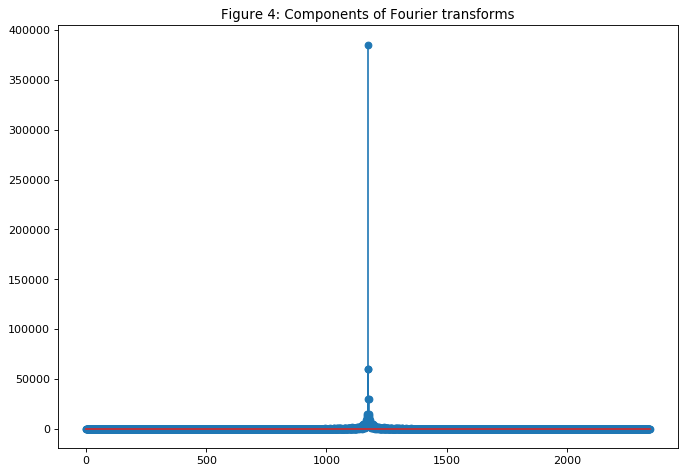

In [36]:
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [37]:
series = data_FT['GS']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.GS   No. Observations:                 2346
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5551.283
Method:                       css-mle   S.D. of innovations              2.579
Date:                Fri, 10 May 2019   AIC                          11116.566
Time:                        10:42:04   BIC                          11156.889
Sample:                             1   HQIC                         11131.252
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0219      0.051      0.433      0.665      -0.077       0.121
ar.L1.D.GS    -0.0159      0.021     -0.772      0.440      -0.056       0.025
ar.L2.D.GS     0.0169      0.021      0.819      0.4

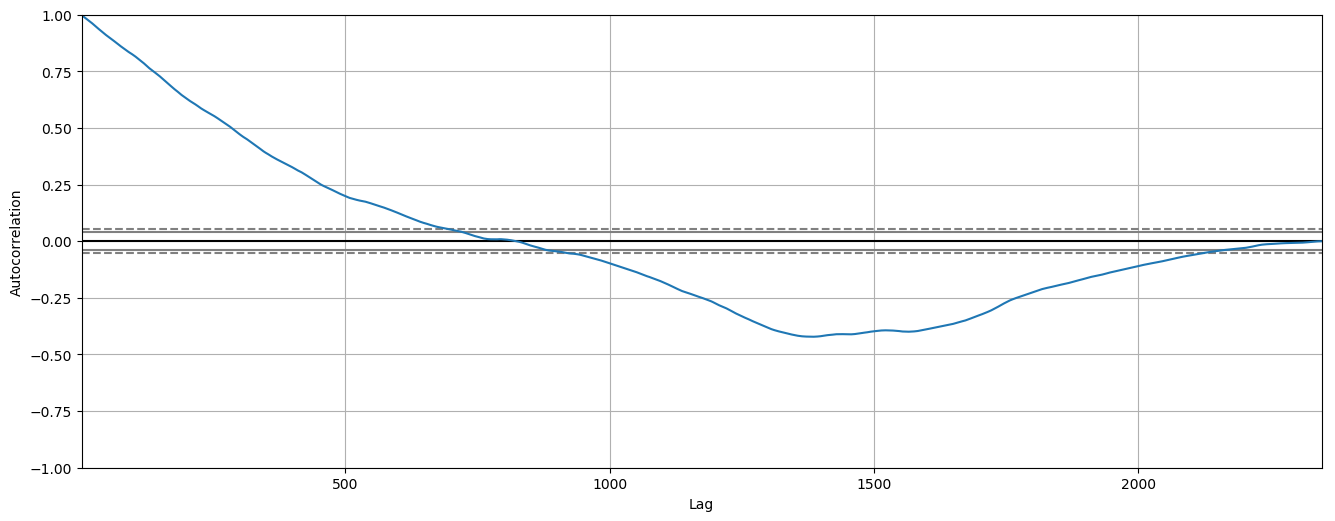

In [38]:
plt.figure(figsize=(16, 6), dpi=100)
autocorrelation_plot(series)
plt.show() 

In [83]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
minlist = []
maxlist = []
diff = []
doubledelta=[]
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    minhat = tuple(tuple(output)[2])[0][0]
    maxhat = tuple(tuple(output)[2])[0][1]
    predictions.append(yhat)
    minlist.append(minhat)
    maxlist.append(maxhat)
    obs = test[t]
    history.append(obs)
    diff.append((obs-yhat))
    doubledelta.append((maxhat-minhat)-(obs-yhat))

In [84]:
error = mean_squared_error(test, predictions)
print('Test Mean Square Error : %.3f ' % error)

Test Mean Square Error : 9.600 


In [85]:
data_FT.head()

,Date,GS
0,2010-01-04,153.149658
1,2010-01-05,155.857300
2,2010-01-06,154.193787
3,2010-01-07,157.211121
4,2010-01-08,154.238022


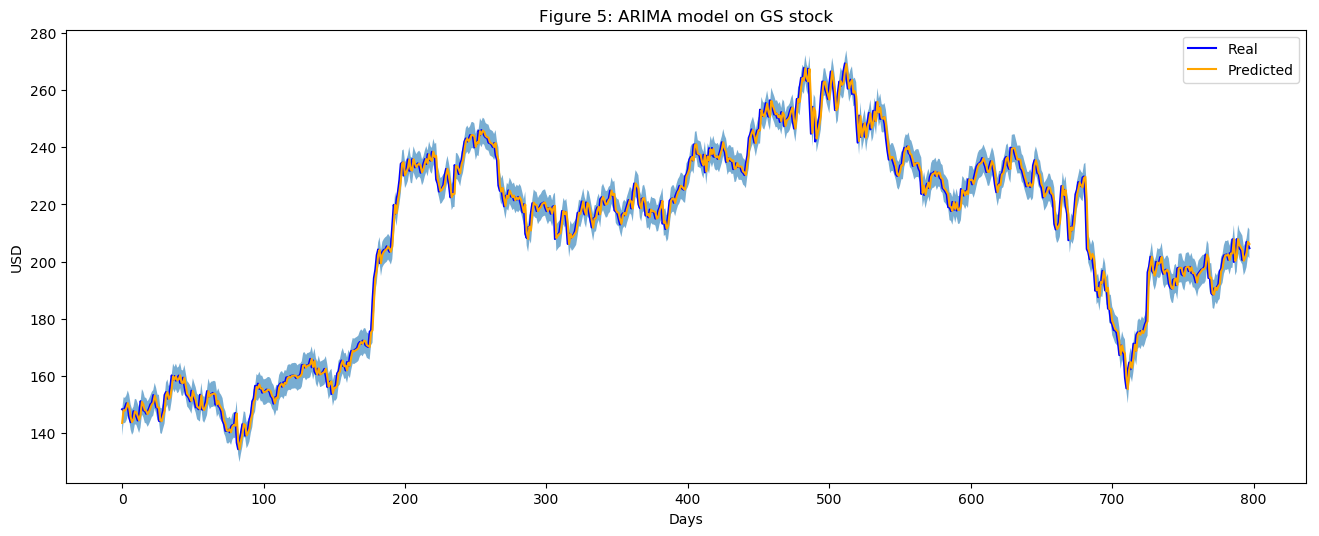

In [119]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(16, 6), dpi=100)
plt.plot(test, color='b',label='Real')
plt.plot(predictions, color='orange', label='Predicted')
#plt.plot(minlist,color='purple',label="Prediction's Range")
#plt.plot(maxlist,color='purple',label="Prediction's Range")
plt.fill_between( x=list(range(0,798)),y1=minlist,y2= maxlist,  alpha=0.6)
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

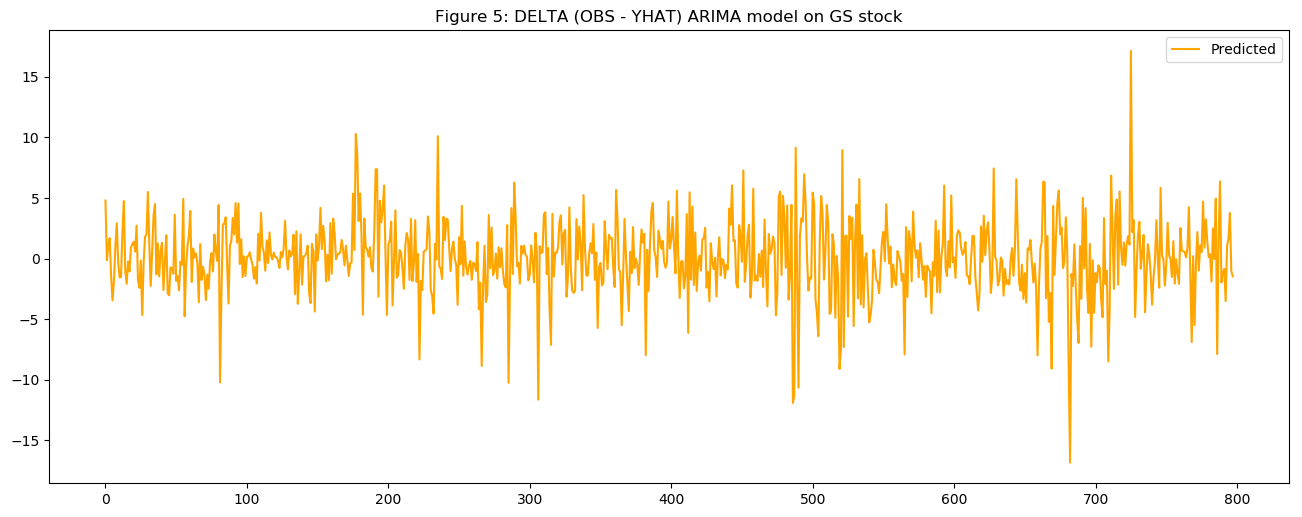

In [89]:
plt.figure(figsize=(16, 6), dpi=100)
plt.plot(diff, color='orange', label='Predicted')
plt.title('Figure 5: DELTA (OBS - YHAT) ARIMA model on GS stock')
plt.legend()
plt.show()

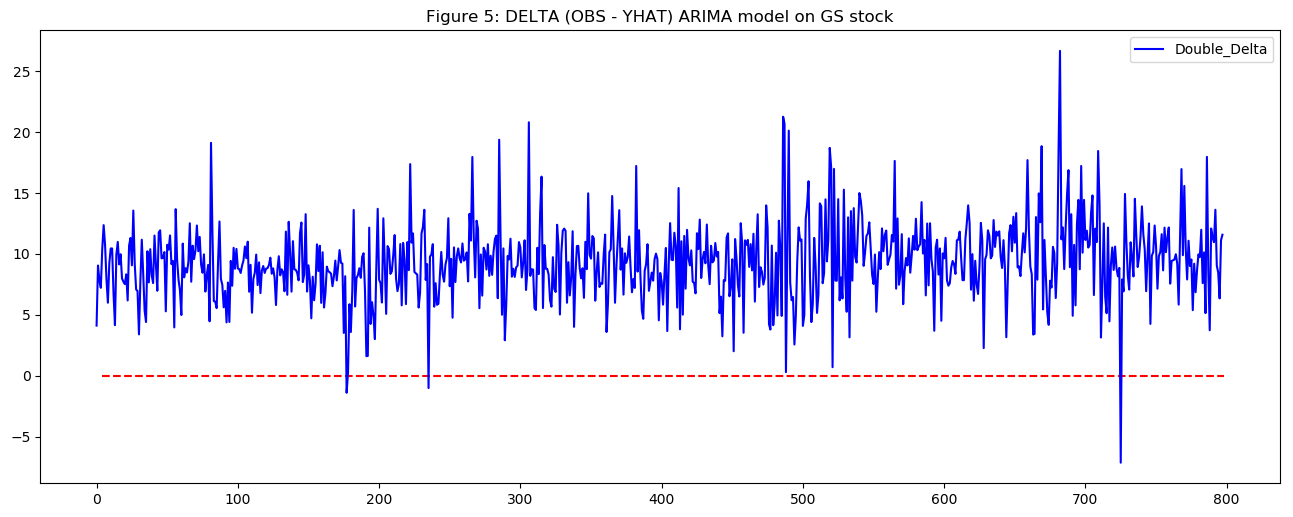

In [97]:
plt.figure(figsize=(16, 6), dpi=100)
plt.plot(doubledelta, color='b', label='Double_Delta')
plt.title('Figure 5: DELTA (OBS - YHAT) ARIMA model on GS stock')
plt.hlines(0, doubledelta, len(doubledelta), colors='red', linestyles='--')
plt.legend()
plt.show()

In [42]:
len(dataset_TI_df),len(predictions),len(history),len(fft_list),len(output),len(yhat)

(2318, 798, 2347, 2346, 3, 1)

In [43]:
dataset_total_df = pd.DataFrame()
dataset_total_df['bsesensex'] = bsesensex.iloc[:,-1] #-1795
dataset_total_df['nikkei'] = nikkei.iloc[:,-1] #1798
dataset_total_df = dataset_TI_df.iloc[-2291:,:]
dataset_total_df['ARIMA_Pred'] = history[-1795]
dataset_total_df['fft_list'] = fft_list[-1795]
dataset_total_df['jpm'] = jpm.iloc[:,-1]
dataset_total_df['ms'] = ms.iloc[:,-1]
#dataset_total_df['ulbr'] = ulbr.iloc[:,-1]
#dataset_total_df['dlbr'] = dlbr.iloc[:,-1]
dataset_total_df['nasdaq'] = nasdaq.iloc[:,-1]
dataset_total_df['nyse'] = nyse.iloc[:,-1]
dataset_total_df['vix'] = vix.iloc[:,-1]
dataset_total_df['per'] = per.iloc[:,-1]
dataset_total_df['schd'] = schd.iloc[:,-1]
#dataset_total_df['spyd'] = spyd.iloc[:,-1]

In [44]:
dataset_total_df['vym'] = vym.iloc[-2291:,-1]
dataset_total_df['eurusd'] = eurusd.iloc[-2291:].values
dataset_total_df['gbpjpy'] = gbpjpy.iloc[-2291:].values
dataset_total_df['usdjpy'] = usdjpy.iloc[-2291:].values
dataset_total_df['gbpusd'] = gbpusd.iloc[-2291:].values
dataset_total_df['btcusd'] = btcusd.iloc[-2291:].values
#dataset_total_df['ethusd'] = ethusd.iloc[-2291:].values
dataset_total_df['gbpeur'] = gbpeur.iloc[-2291:].values
dataset_total_df['gbpsgd'] = gbpsgd.iloc[-2291:].values
dataset_total_df['gbpsek'] = gbpsek.iloc[-2291:].values
dataset_total_df['gbpsar'] = gbpsar.iloc[-2291:].values
dataset_total_df['cadusd'] = cadusd.iloc[-2291:].values
dataset_total_df['cadjpy'] = cadjpy.iloc[-2291:].values
dataset_total_df['audusd'] = audusd.iloc[-2291:].values
dataset_total_df['nzdusd'] = nzdusd.iloc[-2291:].values
dataset_total_df['nzdgbp'] = nzdgbp.iloc[-2291:].values
dataset_total_df['nzdeur'] = nzdeur.iloc[-2291:].values
dataset_total_df['audgbp'] = audgbp.iloc[-2291:].values
dataset_total_df['audeur'] = audeur.iloc[-2291:].values

In [45]:
dataset_total_df.shape

(2291, 39)

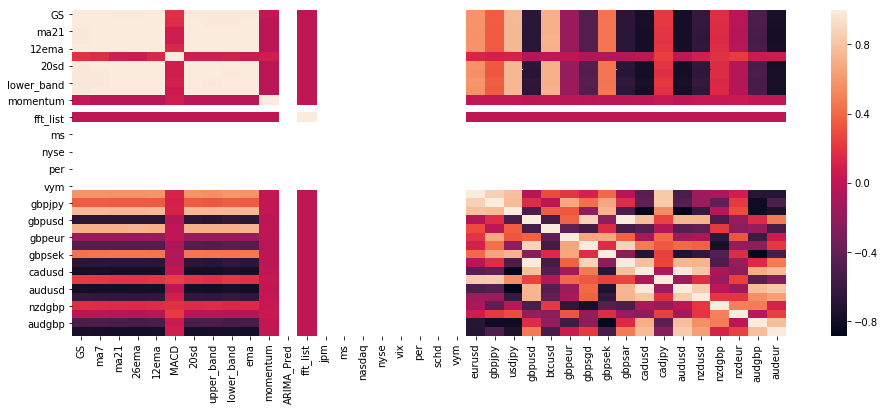

In [46]:
plt.figure(figsize=(16,6))
sns.heatmap(dataset_total_df.corr())
plt.show()

In [47]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], \
                                                              dataset_total_df.shape[1]))

Total dataset has 2291 samples, and 39 features.


In [48]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['GS']
    X = data.iloc[:, 2:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [49]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [50]:
dataset_TI_df.head()

,Date,GS,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
29,2010-02-16,139.275238,136.110003,137.739806,141.431635,137.073431,-4.358204,137.317503,145.925169,128.709837,142.207031,0.022543
30,2010-02-17,139.151352,136.501862,137.404829,141.262725,137.393111,-3.869614,136.892776,144.152791,129.632760,142.009890,-0.000890
31,2010-02-18,137.797516,137.087121,136.935859,141.006043,137.455327,-3.550715,136.359212,141.352400,131.366023,141.738124,-0.009729
32,2010-02-19,138.195740,137.553569,136.446665,140.797872,137.569237,-3.228635,136.151717,140.425691,131.877744,141.509583,0.002890
33,2010-02-22,138.664688,137.942904,136.271383,140.639858,137.737768,-2.902091,136.266307,140.678511,131.854103,141.326042,0.003393


In [51]:
X_train_FI.head()

,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
29,136.110003,137.739806,141.431635,137.073431,-4.358204,137.317503,145.925169,128.709837,142.207031,0.022543
30,136.501862,137.404829,141.262725,137.393111,-3.869614,136.892776,144.152791,129.632760,142.009890,-0.000890
31,137.087121,136.935859,141.006043,137.455327,-3.550715,136.359212,141.352400,131.366023,141.738124,-0.009729
32,137.553569,136.446665,140.797872,137.569237,-3.228635,136.151717,140.425691,131.877744,141.509583,0.002890
33,137.942904,136.271383,140.639858,137.737768,-2.902091,136.266307,140.678511,131.854103,141.326042,0.003393


In [52]:
y_train_FI.head()

29    139.275238
30    139.151352
31    137.797516
32    138.195740
33    138.664688
Name: GS, dtype: float64

In [53]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [54]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [55]:
eval_result = regressor.evals_result()


In [56]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

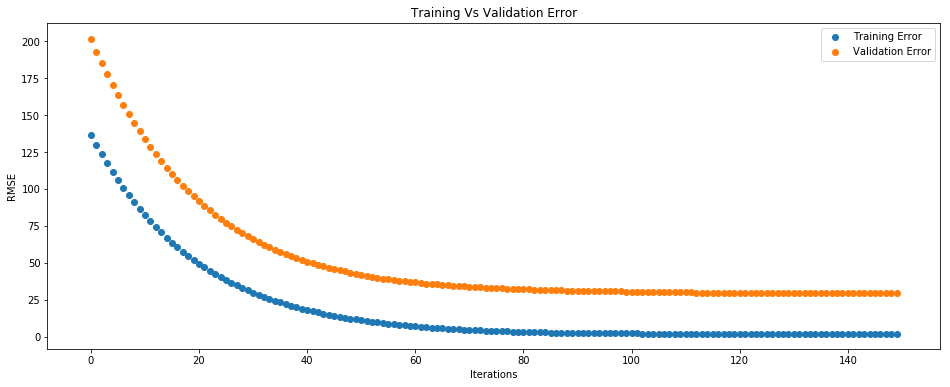

In [57]:
plt.figure(figsize=(16,6))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

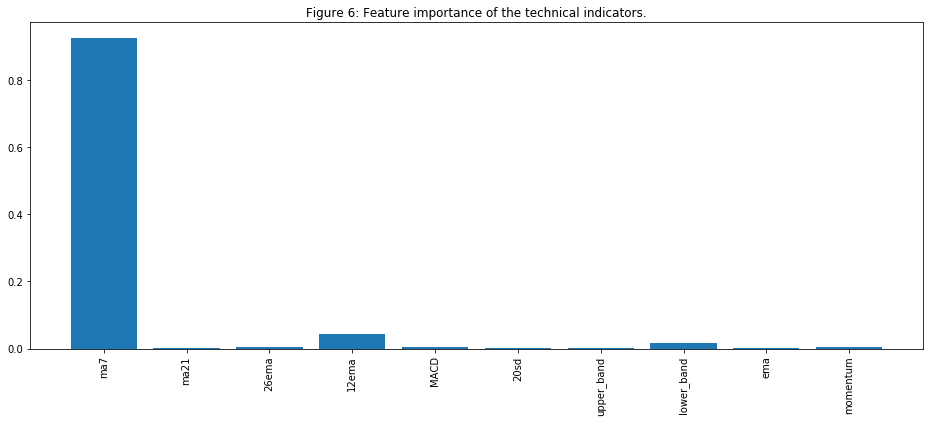

In [58]:
fig = plt.figure(figsize=(16,6))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [59]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

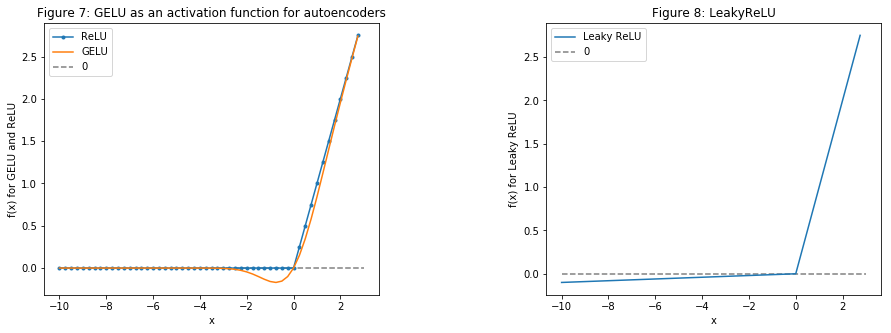

In [60]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [61]:
VAE_data = dataset_ex_df2.iloc[:,2:].dropna().to_numpy()

In [62]:
dataset_ex_df2.head()

,Date,GS,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2010-01-04,153.149658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,155.857300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017680
2,2010-01-06,154.193787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010673
3,2010-01-07,157.211121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019568
4,2010-01-08,154.238022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018912


In [63]:
dataset_ex_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2347 entries, 0 to 2346
Data columns (total 12 columns):
Date          2347 non-null datetime64[ns]
GS            2347 non-null float64
ma7           2341 non-null float64
ma21          2327 non-null float64
26ema         2322 non-null float64
12ema         2336 non-null float64
MACD          2322 non-null float64
20sd          2328 non-null float64
upper_band    2328 non-null float64
lower_band    2328 non-null float64
ema           2318 non-null float64
momentum      2346 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 220.1 KB


In [64]:
#VAE_data = VAE_data.reshape(2289,39)

In [65]:
VAE_data

array([[ 1.36110003e+02,  1.37739806e+02,  1.41431635e+02, ...,
         1.28709837e+02,  1.42207031e+02,  2.25427774e-02],
       [ 1.36501862e+02,  1.37404829e+02,  1.41262725e+02, ...,
         1.29632760e+02,  1.42009890e+02, -8.89505630e-04],
       [ 1.37087121e+02,  1.36935859e+02,  1.41006043e+02, ...,
         1.31366023e+02,  1.41738124e+02, -9.72923397e-03],
       ...,
       [ 2.03798571e+02,  2.02130952e+02,  2.01245972e+02, ...,
         1.96757179e+02,  2.00742179e+02,  1.89087862e-02],
       [ 2.03799999e+02,  2.02794285e+02,  2.01592197e+02, ...,
         1.97717560e+02,  2.01076232e+02, -4.83278566e-03],
       [ 2.03818569e+02,  2.03174760e+02,  2.01824626e+02, ...,
         1.98695759e+02,  2.01311959e+02, -5.77895519e-03]])

In [66]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

In [73]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [74]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE( n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='relu')

In [75]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

In [76]:
print(net)

VAE(
  (encoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 4, linear)
  )
  (decoder): HybridSequential(
    (0): Dense(None -> 400, Activation(relu))
    (1): Dense(None -> 400, Activation(relu))
    (2): Dense(None -> 400, Activation(relu))
    (3): Dense(None -> 9, Activation(sigmoid))
  )
)


In [77]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

Training completed in 58 seconds.


In [78]:
dataset_total_df['Date'] = dataset_ex_df['Date']

In [79]:
dataset_total_df = dataset_total_df.drop(['fft_list'],axis=1)

In [80]:
dataset_total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291 entries, 56 to 2346
Data columns (total 38 columns):
Date          2291 non-null datetime64[ns]
GS            2291 non-null float64
ma7           2291 non-null float64
ma21          2291 non-null float64
26ema         2291 non-null float64
12ema         2291 non-null float64
MACD          2291 non-null float64
20sd          2291 non-null float64
upper_band    2291 non-null float64
lower_band    2291 non-null float64
ema           2291 non-null float64
momentum      2291 non-null float64
ARIMA_Pred    2291 non-null float64
jpm           0 non-null float64
ms            0 non-null float64
nasdaq        0 non-null float64
nyse          0 non-null float64
vix           0 non-null float64
per           0 non-null float64
schd          0 non-null float64
vym           0 non-null float64
eurusd        2288 non-null float64
gbpjpy        2286 non-null float64
usdjpy        2287 non-null float64
gbpusd        2287 non-null float64
btcusd   

In [81]:
vae_added_df = mx.nd.array(dataset_total_df.values)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
vae_added_df

In [159]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))

The shape of the newly created (from the autoencoder) features is (2291, 36).


AttributeError: 'NDArray' object has no attribute 'info'

In [160]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)

In [161]:
x_pca = StandardScaler().fit_transform(vae_added_df)

ValueError: setting an array element with a sequence.

In [ ]:
principalComponents = pca.fit_transform(x_pca)

In [ ]:
principalComponents.n_components_

In [ ]:
gan_num_features = dataset_total_df.shape[1]
sequence_length = 17

class RNNModel(gluon.Block):
    def __init__(self, num_embed, num_hidden, num_layers, bidirectional=False, \
                 sequence_length=sequence_length, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.num_hidden = num_hidden
        with self.name_scope():
            self.rnn = rnn.LSTM(num_hidden, num_layers, input_size=num_embed, \
                                bidirectional=bidirectional, layout='TNC')
            
            self.decoder = nn.Dense(1, in_units=num_hidden)
    
    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        decoded = self.decoder(output.reshape((-1, self.num_hidden)))
        return decoded, hidden
    
    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)
    
lstm_model = RNNModel(num_embed=gan_num_features, num_hidden=500, num_layers=1)
lstm_model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
trainer = gluon.Trainer(lstm_model.collect_params(), 'adam', {'learning_rate': .01})
loss = gluon.loss.L1Loss()

In [ ]:
print(lstm_model)

In [ ]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):     
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs
    
    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length
        
        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

In [ ]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
iterations=1500
plt.figure(figsize=(16,6))
plt.plot([i+1 for i in range(iterations)],[schedule(i) for i in range(iterations)],color=('purple'))
plt.title('Learning rate for each epoch')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
num_fc = 512

# ... other parts of the GAN

cnn_net = gluon.nn.Sequential()
with net.name_scope():
    
    # Add the 1D Convolutional layers
    cnn_net.add(gluon.nn.Conv1D(32, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(gluon.nn.Conv1D(64, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    cnn_net.add(gluon.nn.Conv1D(128, kernel_size=5, strides=2))
    cnn_net.add(nn.LeakyReLU(0.01))
    cnn_net.add(nn.BatchNorm())
    
    # Add the two Fully Connected layers
    cnn_net.add(nn.Dense(220, use_bias=False), nn.BatchNorm(), nn.LeakyReLU(0.01))
    cnn_net.add(nn.Dense(220, use_bias=False), nn.Activation(activation='relu'))
    cnn_net.add(nn.Dense(1))
    
# ... other parts of the GAN

In [ ]:
print(cnn_net)

In [ ]:
# Initialize the optimizer
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [ ]:
from utils import plot_prediction

In [ ]:
plot_prediction('Predicted and Real price - after first epoch.')